In [41]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [51]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from google.colab import drive
from google.colab import files
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from scipy.stats import uniform
import catboost as cb
import lightgbm as lgb

In [24]:
base_path = '/content/drive/MyDrive/ML Sprint/Masterskaya'

train_dir = 'train'
test_dir = 'test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_file_path = os.path.join(base_path, 'heart_train.csv')
test_file_path = os.path.join(base_path, 'heart_test.csv')

try:
    train_df = pd.read_csv(train_file_path)
    test_df = pd.read_csv(test_file_path)
    print("Данные успешно загружены.")
except FileNotFoundError:
    print("Убедитесь, что файлы 'heart_train.csv' и 'heart_test.csv' находятся по указанному пути.")
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")

if 'train_df' in locals():
    print("\nПервые строки обучающего набора данных:")
    display(train_df.head())

if 'test_df' in locals():
    print("\nПервые строки тестового набора данных:")
    display(test_df.head())

Данные успешно загружены.

Первые строки обучающего набора данных:


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047



Первые строки тестового набора данных:


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [25]:
train_df = pd.get_dummies(train_df, columns=['Gender'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Gender'], drop_first=True)

print("Обучающий набор данных после One-Hot Encoding и обработки пропусков:")
display(train_df.head())

print("\nТестовый набор данных после One-Hot Encoding и обработки пропусков:")
display(test_df.head())

Обучающий набор данных после One-Hot Encoding и обработки пропусков:


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id,Gender_1.0,Gender_Female,Gender_Male
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,0.0,0.227018,0.048229,0.036512,0.212903,0.709302,2664,False,False,True
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,0.0,0.150198,0.017616,0.000194,0.412903,0.569767,9287,False,True,False
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,0.0,0.227018,0.048229,0.036512,0.238710,0.220930,5379,False,True,False
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,1.0,0.227018,0.048229,0.036512,0.348387,0.267442,8222,False,True,False
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,1.0,0.227018,0.048229,0.036512,0.619355,0.441860,4047,False,False,True



Тестовый набор данных после One-Hot Encoding и обработки пропусков:


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id,Gender_1.0,Gender_Female,Gender_Male
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.333333,0.227018,0.048229,0.036512,0.283871,0.372093,7746,False,False,True
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.166667,0.227018,0.048229,0.036512,0.703226,0.441860,4202,False,True,False
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,1.000000,0.102767,0.002666,0.088455,0.458065,0.779070,6632,False,False,True
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.666667,0.203557,0.056390,0.271774,0.741935,0.255814,4639,False,True,False
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.000000,0.227018,0.048229,0.036512,0.412903,0.395349,4825,False,False,True


In [26]:
train_df = pd.get_dummies(train_df, columns=['Gender'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Gender'], drop_first=True)

print("Обучающий набор данных после One-Hot Encoding и обработки пропусков:")
display(train_df.head())

print("\nТестовый набор данных после One-Hot Encoding и обработки пропусков:")
display(test_df.head())

KeyError: "None of [Index(['Gender'], dtype='object')] are in the [columns]"

In [27]:
columns_to_keep = [
    'id', # Keep id initially to set as index
    'Age',
    'Gender_Female',
    'Gender_Male',# Keep Gender before encoding
    'Family History',
    'Smoking',
    'BMI',
    'Alcohol Consumption',
    'Physical Activity Days Per Week',
    'Cholesterol',
    'Blood sugar',
    'Diabetes',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Heart rate',
    'Troponin',
    'CK-MB',
    'Heart Attack Risk (Binary)' # Keep the target variable in train_df
]

train_cols_to_keep = [col for col in columns_to_keep if col in train_df.columns]
train_df = train_df[train_cols_to_keep]

test_cols_to_keep = [col for col in columns_to_keep if col in test_df.columns and col != 'Heart Attack Risk (Binary)']
test_df = test_df[test_cols_to_keep]

train_df.set_index('id', inplace=True)
test_df.set_index('id', inplace=True)


print("Обучающий набор данных после отбора столбцов и установки 'id' в качестве индекса:")
display(train_df.head())

print("\nТестовый набор данных после отбора столбцов и установки 'id' в качестве индекса:")
display(test_df.head())

Обучающий набор данных после отбора столбцов и установки 'id' в качестве индекса:


,Age,Gender_Female,Gender_Male,Family History,Smoking,BMI,Alcohol Consumption,Physical Activity Days Per Week,Cholesterol,Blood sugar,Diabetes,Systolic blood pressure,Diastolic blood pressure,Heart rate,Troponin,CK-MB,Heart Attack Risk (Binary)
id,,,,,,,,,,,,,,,,,
2664,0.359551,False,True,1.0,1.0,0.459176,1.0,3.0,0.732143,0.227018,1.0,0.212903,0.709302,0.074244,0.036512,0.048229,0.0
9287,0.202247,True,False,1.0,0.0,0.117053,1.0,3.0,0.325000,0.150198,1.0,0.412903,0.569767,0.047663,0.000194,0.017616,0.0
5379,0.606742,True,False,0.0,1.0,0.373574,1.0,2.0,0.860714,0.227018,1.0,0.238710,0.220930,0.055912,0.036512,0.048229,0.0
8222,0.730337,True,False,0.0,1.0,0.049735,1.0,0.0,0.007143,0.227018,0.0,0.348387,0.267442,0.053162,0.036512,0.048229,1.0
4047,0.775281,False,True,0.0,1.0,0.830405,1.0,5.0,0.757143,0.227018,0.0,0.619355,0.441860,0.021998,0.036512,0.048229,1.0



Тестовый набор данных после отбора столбцов и установки 'id' в качестве индекса:


,Age,Gender_Female,Gender_Male,Family History,Smoking,BMI,Alcohol Consumption,Physical Activity Days Per Week,Cholesterol,Blood sugar,Diabetes,Systolic blood pressure,Diastolic blood pressure,Heart rate,Troponin,CK-MB
id,,,,,,,,,,,,,,,,
7746,0.494382,False,True,1.0,1.0,0.283490,1.0,1.0,0.264286,0.227018,0.0,0.283871,0.372093,0.062328,0.036512,0.048229
4202,0.224719,True,False,0.0,0.0,0.467036,0.0,0.0,0.953571,0.227018,1.0,0.703226,0.441860,0.082493,0.036512,0.048229
6632,0.629213,False,True,1.0,1.0,0.409366,0.0,7.0,0.092857,0.102767,0.0,0.458065,0.779070,0.064161,0.088455,0.002666
4639,0.460674,True,False,1.0,1.0,0.910261,1.0,0.0,0.567857,0.203557,1.0,0.741935,0.255814,0.055912,0.271774,0.056390
4825,0.719101,False,True,0.0,1.0,0.758924,1.0,5.0,0.485714,0.227018,1.0,0.412903,0.395349,0.022915,0.036512,0.048229


In [28]:

print("\nПроверка пропущенных значений в обучающем наборе данных:")
print(train_df.isnull().sum())

print("\nПроверка пропущенных значений в тестовом наборе данных:")
print(test_df.isnull().sum())


Проверка пропущенных значений в обучающем наборе данных:
Age                                  0
Gender_Female                        0
Gender_Male                          0
Family History                     243
Smoking                            243
BMI                                  0
Alcohol Consumption                243
Physical Activity Days Per Week    243
Cholesterol                          0
Blood sugar                          0
Diabetes                           243
Systolic blood pressure              0
Diastolic blood pressure             0
Heart rate                           0
Troponin                             0
CK-MB                                0
Heart Attack Risk (Binary)           0
dtype: int64

Проверка пропущенных значений в тестовом наборе данных:
Age                                 0
Gender_Female                       0
Gender_Male                         0
Family History                     31
Smoking                            31
BMI                

In [29]:
train_df.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

print("Пропущенные значения в обучающем наборе данных после заполнения:")
print(train_df.isnull().sum())

print("\nПропущенные значения в тестовом наборе данных после заполнения:")
print(test_df.isnull().sum())

print("\nПервые строки обучающего набора данных после заполнения пропусков:")
display(train_df.head())

print("\nПервые строки тестового набора данных после заполнения пропусков:")
display(test_df.head())

Пропущенные значения в обучающем наборе данных после заполнения:
Age                                0
Gender_Female                      0
Gender_Male                        0
Family History                     0
Smoking                            0
BMI                                0
Alcohol Consumption                0
Physical Activity Days Per Week    0
Cholesterol                        0
Blood sugar                        0
Diabetes                           0
Systolic blood pressure            0
Diastolic blood pressure           0
Heart rate                         0
Troponin                           0
CK-MB                              0
Heart Attack Risk (Binary)         0
dtype: int64

Пропущенные значения в тестовом наборе данных после заполнения:
Age                                0
Gender_Female                      0
Gender_Male                        0
Family History                     0
Smoking                            0
BMI                                0
Alcoho

/tmp/ipython-input-3581657891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.fillna(-1, inplace=True)


,Age,Gender_Female,Gender_Male,Family History,Smoking,BMI,Alcohol Consumption,Physical Activity Days Per Week,Cholesterol,Blood sugar,Diabetes,Systolic blood pressure,Diastolic blood pressure,Heart rate,Troponin,CK-MB,Heart Attack Risk (Binary)
id,,,,,,,,,,,,,,,,,
2664,0.359551,False,True,1.0,1.0,0.459176,1.0,3.0,0.732143,0.227018,1.0,0.212903,0.709302,0.074244,0.036512,0.048229,0.0
9287,0.202247,True,False,1.0,0.0,0.117053,1.0,3.0,0.325000,0.150198,1.0,0.412903,0.569767,0.047663,0.000194,0.017616,0.0
5379,0.606742,True,False,0.0,1.0,0.373574,1.0,2.0,0.860714,0.227018,1.0,0.238710,0.220930,0.055912,0.036512,0.048229,0.0
8222,0.730337,True,False,0.0,1.0,0.049735,1.0,0.0,0.007143,0.227018,0.0,0.348387,0.267442,0.053162,0.036512,0.048229,1.0
4047,0.775281,False,True,0.0,1.0,0.830405,1.0,5.0,0.757143,0.227018,0.0,0.619355,0.441860,0.021998,0.036512,0.048229,1.0



Первые строки тестового набора данных после заполнения пропусков:


,Age,Gender_Female,Gender_Male,Family History,Smoking,BMI,Alcohol Consumption,Physical Activity Days Per Week,Cholesterol,Blood sugar,Diabetes,Systolic blood pressure,Diastolic blood pressure,Heart rate,Troponin,CK-MB
id,,,,,,,,,,,,,,,,
7746,0.494382,False,True,1.0,1.0,0.283490,1.0,1.0,0.264286,0.227018,0.0,0.283871,0.372093,0.062328,0.036512,0.048229
4202,0.224719,True,False,0.0,0.0,0.467036,0.0,0.0,0.953571,0.227018,1.0,0.703226,0.441860,0.082493,0.036512,0.048229
6632,0.629213,False,True,1.0,1.0,0.409366,0.0,7.0,0.092857,0.102767,0.0,0.458065,0.779070,0.064161,0.088455,0.002666
4639,0.460674,True,False,1.0,1.0,0.910261,1.0,0.0,0.567857,0.203557,1.0,0.741935,0.255814,0.055912,0.271774,0.056390
4825,0.719101,False,True,0.0,1.0,0.758924,1.0,5.0,0.485714,0.227018,1.0,0.412903,0.395349,0.022915,0.036512,0.048229


In [30]:
X_train = train_df.drop('Heart Attack Risk (Binary)', axis=1)
y_train = train_df['Heart Attack Risk (Binary)']


X_test = test_df.copy()

train_cols = X_train.columns
test_cols = X_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0

X_test = X_test[train_cols]


print("Размерность обучающих признаков:", X_train.shape)
print("Размерность целевой переменной (обучение):", y_train.shape)
print("Размерность тестовых признаков:", X_test.shape)

if list(X_train.columns) == list(X_test.columns):
    print("\nСтолбцы в обучающих и тестовых признаках совпадают.")
else:
    print("\nВНИМАНИЕ: Столбцы в обучающих и тестовых признаках НЕ совпадают.")
    print("Столбцы в X_train:", list(X_train.columns))
    print("Столбцы в X_test:", list(X_test.columns))


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("\nМодель RandomForestClassifier успешно обучена.")

y_train_pred_proba = model.predict_proba(X_train)[:, 1]

roc_auc = roc_auc_score(y_train, y_train_pred_proba)

print(f"\nROC-AUC на обучающем наборе данных: {roc_auc:.4f}")

y_train_pred_class = model.predict(X_train)

f1 = f1_score(y_train, y_train_pred_class)

print(f"F1-мера на обучающем наборе данных: {f1:.4f}")

print("\nОтчет по классификации на обучающем наборе данных:")
print(classification_report(y_train, y_train_pred_class))


Размерность обучающих признаков: (8685, 16)
Размерность целевой переменной (обучение): (8685,)
Размерность тестовых признаков: (966, 16)

Столбцы в обучающих и тестовых признаках совпадают.

Модель RandomForestClassifier успешно обучена.

ROC-AUC на обучающем наборе данных: 1.0000
F1-мера на обучающем наборе данных: 1.0000

Отчет по классификации на обучающем наборе данных:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5672
         1.0       1.00      1.00      1.00      3013

    accuracy                           1.00      8685
   macro avg       1.00      1.00      1.00      8685
weighted avg       1.00      1.00      1.00      8685



In [31]:
param_dist = {'n_estimators': randint(100, 200),
              'max_depth': randint(3, 10),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 5)}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=10, # Number of parameter settings sampled (reduce for speed)
                                   cv=5,
                                   scoring='roc_auc',
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:", random_search.best_params_)
print(f"Лучшее значение ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")

best_rf_model = random_search.best_estimator_

print("\nМодель RandomForestClassifier с лучшими гиперпараметрами успешно обучена.")

Лучшие гиперпараметры: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 186}
Лучшее значение ROC-AUC на кросс-валидации: 0.5626

Модель RandomForestClassifier с лучшими гиперпараметрами успешно обучена.


In [32]:

cv_scores_tuned = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='roc_auc')

print("Результаты кросс-валидации (ROC-AUC) для модели с лучшими гиперпараметрами:", cv_scores_tuned)
print(f"Среднее значение ROC-AUC при кросс-валидации для модели с лучшими гиперпараметрами: {cv_scores_tuned.mean():.4f}")
print(f"Стандартное отклонение ROC-AUC при кросс-валидации для модели с лучшими гиперпараметрами: {cv_scores_tuned.std():.4f}")

y_train_pred_proba_tuned = best_rf_model.predict_proba(X_train)[:, 1]
roc_auc_tuned = roc_auc_score(y_train, y_train_pred_proba_tuned)
print(f"\nROC-AUC на обучающем наборе данных для модели с лучшими гиперпараметрами: {roc_auc_tuned:.4f}")

y_train_pred_class_tuned = best_rf_model.predict(X_train)
f1_tuned = f1_score(y_train, y_train_pred_class_tuned)
print(f"F1-мера на обучающем наборе данных для модели с лучшими гиперпараметрами: {f1_tuned:.4f}")

print("\nОтчет по классификации на обучающем наборе данных для модели с лучшими гиперпараметрами:")
print(classification_report(y_train, y_train_pred_class_tuned))

Результаты кросс-валидации (ROC-AUC) для модели с лучшими гиперпараметрами: [0.54932457 0.55506754 0.56798313 0.58044288 0.56013437]
Среднее значение ROC-AUC при кросс-валидации для модели с лучшими гиперпараметрами: 0.5626
Стандартное отклонение ROC-AUC при кросс-валидации для модели с лучшими гиперпараметрами: 0.0108

ROC-AUC на обучающем наборе данных для модели с лучшими гиперпараметрами: 0.8860
F1-мера на обучающем наборе данных для модели с лучшими гиперпараметрами: 0.0320

Отчет по классификации на обучающем наборе данных для модели с лучшими гиперпараметрами:
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79      5672
         1.0       1.00      0.02      0.03      3013

    accuracy                           0.66      8685
   macro avg       0.83      0.51      0.41      8685
weighted avg       0.78      0.66      0.53      8685



In [33]:
print("Распределение классов до балансировки:")
print(y_train.value_counts())

if len(X_train.shape) == 1:
    X_train_res = X_train.values.reshape(-1, 1)
else:
    X_train_res = X_train

smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_res, y_train)

print("\nРаспределение классов после балансировки с помощью SMOTE:")
print(y_train_balanced.value_counts())

if isinstance(X_train, pd.DataFrame):
    X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)

print("\nРазмерность обучающих признаков после балансировки:", X_train_balanced.shape)
print("Размерность целевой переменной (обучение) после балансировки:", y_train_balanced.shape)

X_train = X_train_balanced
y_train = y_train_balanced

print("\nОбучающие данные обновлены с учетом балансировки классов.")

Распределение классов до балансировки:
Heart Attack Risk (Binary)
0.0    5672
1.0    3013
Name: count, dtype: int64

Распределение классов после балансировки с помощью SMOTE:
Heart Attack Risk (Binary)
0.0    5672
1.0    5672
Name: count, dtype: int64

Размерность обучающих признаков после балансировки: (11344, 16)
Размерность целевой переменной (обучение) после балансировки: (11344,)

Обучающие данные обновлены с учетом балансировки классов.


In [34]:
best_rf_model.fit(X_train, y_train)

print("\nМодель RandomForestClassifier с лучшими гиперпараметрами успешно обучена на сбалансированных данных.")


cv_scores_tuned_balanced = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='roc_auc')

print("\nРезультаты кросс-валидации (ROC-AUC) для модели с лучшими гиперпараметрами на сбалансированных данных:", cv_scores_tuned_balanced)
print(f"Среднее значение ROC-AUC при кросс-валидации для модели с лучшими гиперпараметрами на сбалансированных данных: {cv_scores_tuned_balanced.mean():.4f}")
print(f"Стандартное отклонение ROC-AUC при кросс-валидации для модели с лучшими гиперпараметрами на сбалансированных данных: {cv_scores_tuned_balanced.std():.4f}")

y_train_pred_proba_tuned_balanced = best_rf_model.predict_proba(X_train)[:, 1]
roc_auc_tuned_balanced = roc_auc_score(y_train, y_train_pred_proba_tuned_balanced)
print(f"\nROC-AUC на сбалансированном обучающем наборе данных для модели с лучшими гиперпараметрами: {roc_auc_tuned_balanced:.4f}")

y_train_pred_class_tuned_balanced = best_rf_model.predict(X_train)
f1_tuned_balanced = f1_score(y_train, y_train_pred_class_tuned_balanced)
print(f"F1-мера на сбалансированном обучающем наборе данных для модели с лучшими гиперпараметрами: {f1_tuned_balanced:.4f}")

print("\nОтчет по классификации на сбалансированном обучающем наборе данных для модели с лучшими гиперпараметрами:")
print(classification_report(y_train, y_train_pred_class_tuned_balanced))


Модель RandomForestClassifier с лучшими гиперпараметрами успешно обучена на сбалансированных данных.

Результаты кросс-валидации (ROC-AUC) для модели с лучшими гиперпараметрами на сбалансированных данных: [0.55933851 0.56390113 0.66378653 0.83728488 0.84068662]
Среднее значение ROC-AUC при кросс-валидации для модели с лучшими гиперпараметрами на сбалансированных данных: 0.6930
Стандартное отклонение ROC-AUC при кросс-валидации для модели с лучшими гиперпараметрами на сбалансированных данных: 0.1249

ROC-AUC на сбалансированном обучающем наборе данных для модели с лучшими гиперпараметрами: 0.8149
F1-мера на сбалансированном обучающем наборе данных для модели с лучшими гиперпараметрами: 0.7332

Отчет по классификации на сбалансированном обучающем наборе данных для модели с лучшими гиперпараметрами:
              precision    recall  f1-score   support

         0.0       0.74      0.69      0.71      5672
         1.0       0.71      0.76      0.73      5672

    accuracy               

In [35]:
print("Лучшие гиперпараметры:", random_search.best_params_)

print(f"\nСреднее значение ROC-AUC при кросс-валидации на сбалансированных данных: {cv_scores_tuned_balanced.mean():.4f}")
print(f"ROC-AUC на сбалансированном обучающем наборе данных: {roc_auc_tuned_balanced:.4f}")
print(f"F1-мера на сбалансированном обучающем наборе данных: {f1_tuned_balanced:.4f}")

Лучшие гиперпараметры: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 186}

Среднее значение ROC-AUC при кросс-валидации на сбалансированных данных: 0.6930
ROC-AUC на сбалансированном обучающем наборе данных: 0.8149
F1-мера на сбалансированном обучающем наборе данных: 0.7332


Важность признаков (отсортировано по убыванию) для лучшей модели RF на сбалансированных данных:
Troponin                           0.146606
CK-MB                              0.119300
Systolic blood pressure            0.087395
Heart rate                         0.085425
Diastolic blood pressure           0.080125
BMI                                0.075406
Blood sugar                        0.071584
Age                                0.066818
Cholesterol                        0.064953
Physical Activity Days Per Week    0.056338
Family History                     0.036558
Diabetes                           0.035221
Smoking                            0.032355
Alcohol Consumption                0.030637
Gender_Male                        0.005827
Gender_Female                      0.005451
dtype: float64


/tmp/ipython-input-3359653241.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance_series.values, y=sorted_importance_series.index, palette='viridis')


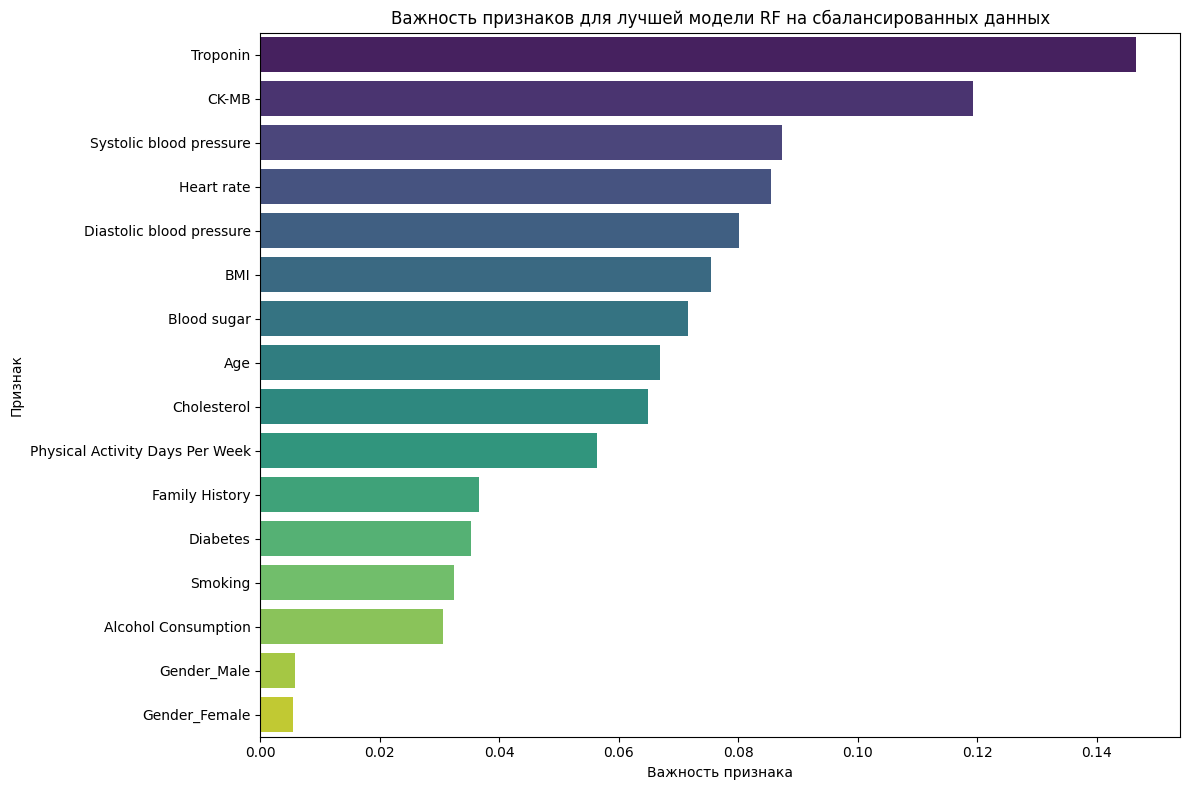

In [36]:
feature_importances = best_rf_model.feature_importances_

importance_series = pd.Series(feature_importances, index=X_train.columns)

sorted_importance_series = importance_series.sort_values(ascending=False)

print("Важность признаков (отсортировано по убыванию) для лучшей модели RF на сбалансированных данных:")
print(sorted_importance_series)

top_n = len(sorted_importance_series) # Visualize all features
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importance_series.values, y=sorted_importance_series.index, palette='viridis')
plt.title(f'Важность признаков для лучшей модели RF на сбалансированных данных')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

In [37]:
X_test_final = test_df.copy()

train_cols = X_train.columns # X_train now holds the balanced data features
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0


X_test_final = X_test_final[train_cols]


test_predictions_proba = best_rf_model.predict_proba(X_test_final)[:, 1]

test_predictions_binary = (test_predictions_proba >= 0.5).astype(int)


predictions_df = pd.DataFrame({'id': X_test_final.index, 'prediction': test_predictions_binary})

print("Первые строки DataFrame с бинарными предсказаниями:")
display(predictions_df.head())

predictions_output_path = 'predictions.csv'
predictions_df.to_csv(predictions_output_path, index=False)

print(f"\nПредсказания сохранены в файл: {predictions_output_path}")

Первые строки DataFrame с бинарными предсказаниями:


,id,prediction
0,7746,1
1,4202,0
2,6632,1
3,4639,1
4,4825,1



Предсказания сохранены в файл: predictions.csv


## 1. Настройка и обучение CatBoost



In [43]:
catboost_model = cb.CatBoostClassifier(random_state=42, verbose=0, eval_metric='Logloss')

param_dist_catboost = {
    'iterations': randint(50, 200),
    'learning_rate': uniform(0.01, 0.15),
    'depth': randint(3, 8),
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 128),
    'subsample': uniform(0.6, 0.4)
}

random_search_catboost = RandomizedSearchCV(estimator=catboost_model,
                                            param_distributions=param_dist_catboost,
                                            n_iter=10,
                                            cv=5,
                                            scoring='roc_auc',
                                            random_state=42,
                                            n_jobs=-1)

random_search_catboost.fit(X_train, y_train)

print("Лучшие гиперпараметры для CatBoost:", random_search_catboost.best_params_)
print(f"Лучшее значение ROC-AUC на кросс-валидации для CatBoost: {random_search_catboost.best_score_:.4f}")

best_catboost_model = random_search_catboost.best_estimator_

print("\nМодель CatBoostClassifier с лучшими гиперпараметрами успешно обучена на сбалансированных данных.")

Лучшие гиперпараметры для CatBoost: {'border_count': 114, 'depth': 5, 'iterations': 137, 'l2_leaf_reg': 5, 'learning_rate': np.float64(0.10016725176148131), 'subsample': np.float64(0.8832290311184181)}
Лучшее значение ROC-AUC на кросс-валидации для CatBoost: 0.6829

Модель CatBoostClassifier с лучшими гиперпараметрами успешно обучена на сбалансированных данных.


## 2. Настройка и обучение LightGBM


In [44]:
lgb_model = lgb.LGBMClassifier(random_state=42, objective='binary', metric='auc')

param_dist_lgb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.15),
    'num_leaves': randint(20, 60),
    'max_depth': randint(3, 10),
    'min_child_samples': randint(20, 50),
    'subsample': uniform(0.6, 0.4), # Fraction of samples for fitting the individual base learners
    'colsample_bytree': uniform(0.6, 0.4) # Fraction of features for fitting the individual base learners
}


random_search_lgb = RandomizedSearchCV(estimator=lgb_model,
                                       param_distributions=param_dist_lgb,
                                       n_iter=10, # Reduced for faster execution
                                       cv=5,
                                       scoring='roc_auc',
                                       random_state=42,
                                       n_jobs=-1)

random_search_lgb.fit(X_train, y_train)

print("Лучшие гиперпараметры для LightGBM:", random_search_lgb.best_params_)
print(f"Лучшее значение ROC-AUC на кросс-валидации для LightGBM: {random_search_lgb.best_score_:.4f}")

best_lgb_model = random_search_lgb.best_estimator_

print("\nМодель LightGBMClassifier с лучшими гиперпараметрами успешно обучена на сбалансированных данных.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5672, number of negative: 5672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 11344, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

## 3. Настройка и обучение XGBoost


In [45]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_dist_xgb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.15),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}


random_search_xgb = RandomizedSearchCV(estimator=xgb_model,
                                       param_distributions=param_dist_xgb,
                                       n_iter=10, # Reduced for faster execution
                                       cv=5,
                                       scoring='roc_auc',
                                       random_state=42,
                                       n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

print("Лучшие гиперпараметры для XGBoost:", random_search_xgb.best_params_)
print(f"Лучшее значение ROC-AUC на кросс-валидации для XGBoost: {random_search_xgb.best_score_:.4f}")

best_xgb_model = random_search_xgb.best_estimator_

print("\nМодель XGBoostClassifier с лучшими гиперпараметрами успешно обучена на сбалансированных данных.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:35:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Лучшие гиперпараметры для XGBoost: {'colsample_bytree': np.float64(0.9637281608315128), 'learning_rate': np.float64(0.04881699724000254), 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 183, 'subsample': np.float64(0.6831766651472755)}
Лучшее значение ROC-AUC на кросс-валидации для XGBoost: 0.7122

Модель XGBoostClassifier с лучшими гиперпараметрами успешно обучена на сбалансированных данных.


## 4. Подготовка предсказаний ансамбля на тестовой выборке и формирование файла предсказаний


In [46]:
catboost_train_pred_proba = best_catboost_model.predict_proba(X_train)[:, 1]
lightgbm_train_pred_proba = best_lgb_model.predict_proba(X_train)[:, 1]
xgboost_train_pred_proba = best_xgb_model.predict_proba(X_train)[:, 1]

ensemble_train_pred_proba = (catboost_train_pred_proba + lightgbm_train_pred_proba + xgboost_train_pred_proba) / 3

print("Первые 5 предсказаний ансамбля (вероятности) на обучающем наборе:")
print(ensemble_train_pred_proba[:5])

Первые 5 предсказаний ансамбля (вероятности) на обучающем наборе:
[0.34017693 0.45845619 0.33103853 0.47651903 0.57286303]


In [47]:
roc_auc_ensemble = roc_auc_score(y_train, ensemble_train_pred_proba)

ensemble_train_pred_class = (ensemble_train_pred_proba >= 0.5).astype(int)
f1_ensemble = f1_score(y_train, ensemble_train_pred_class)

print(f"ROC-AUC ансамбля на обучающем наборе данных: {roc_auc_ensemble:.4f}")
print(f"F1-мера ансамбля на обучающем наборе данных: {f1_ensemble:.4f}")

print("\nОтчет по классификации ансамбля на обучающем наборе данных:")
print(classification_report(y_train, ensemble_train_pred_class))

ROC-AUC ансамбля на обучающем наборе данных: 0.9345
F1-мера ансамбля на обучающем наборе данных: 0.8444

Отчет по классификации ансамбля на обучающем наборе данных:
              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      5672
         1.0       0.86      0.83      0.84      5672

    accuracy                           0.85     11344
   macro avg       0.85      0.85      0.85     11344
weighted avg       0.85      0.85      0.85     11344



In [48]:
catboost_test_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]
lightgbm_test_pred_proba = best_lgb_model.predict_proba(X_test)[:, 1]
xgboost_test_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

ensemble_test_pred_proba = (catboost_test_pred_proba + lightgbm_test_pred_proba + xgboost_test_pred_proba) / 3

ensemble_test_predictions_binary = (ensemble_test_pred_proba >= 0.5).astype(int)

predictions_df_ensemble = pd.DataFrame({'id': X_test.index, 'prediction': ensemble_test_predictions_binary})

print("Первые строки DataFrame с бинарными предсказаниями ансамбля на тестовом наборе:")
display(predictions_df_ensemble.head())

predictions_output_path_ensemble = 'predictions_ensemble.csv'
predictions_df_ensemble.to_csv(predictions_output_path_ensemble, index=False)

print(f"\nПредсказания ансамбля сохранены в файл: {predictions_output_path_ensemble}")

Первые строки DataFrame с бинарными предсказаниями ансамбля на тестовом наборе:


,id,prediction
0,7746,1
1,4202,0
2,6632,1
3,4639,0
4,4825,0



Предсказания ансамбля сохранены в файл: predictions_ensemble.csv


In [49]:
train_cols = X_train.columns.tolist()
cols_filename = "train_columns.pkl"
joblib.dump(train_cols, cols_filename)

print(f"Список признаков сохранен в файл: {cols_filename}")
files.download(cols_filename)

Список признаков сохранен в файл: train_columns.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>